## Usando C++

In [7]:
from google.colab import drive
drive.mount('/content/drive')

%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'ensamblaje de ADN'/   Lab_3.ipynb   Lab3.ipynb  'parcial '/   Untitled0.ipynb


In [9]:
%cd /content/drive/MyDrive/UCSP/IX CICLO/Molecular
%ls

/content/drive/MyDrive/UCSP/IX CICLO/Molecular
'ensamblaje de ADN'/   Nussinov_Algorithm.ipynb  'parcial '/


In [19]:
%%writefile main.cpp
#include <iostream>
#include <vector>
#include <string>
#include <algorithm>
#include <iomanip>
#include <chrono>
#include <random>
#include <fstream>
#include <ctime>
using namespace std;

class NussinovRNA {
private:
    vector<vector<int>> dp;
    string sequence;

    int alpha(char ri, char rj, bool useComplexEnergy = true) {
        if (useComplexEnergy) {
            if ((ri == 'C' && rj == 'G') || (ri == 'G' && rj == 'C'))
                return -5;
            if ((ri == 'A' && rj == 'U') || (ri == 'U' && rj == 'A'))
                return -4;
            if ((ri == 'G' && rj == 'U') || (ri == 'U' && rj == 'G'))
                return -1;
            return 0;
        } else {
            if ((ri == 'C' && rj == 'G') || (ri == 'G' && rj == 'C') ||
                (ri == 'A' && rj == 'U') || (ri == 'U' && rj == 'A'))
                return -1;
            return 0;
        }
    }

    bool canPair(char a, char b) {
        return ((a == 'A' && b == 'U') || (a == 'U' && b == 'A') ||
                (a == 'C' && b == 'G') || (a == 'G' && b == 'C') ||
                (a == 'G' && b == 'U') || (a == 'U' && b == 'G'));
    }

public:
    NussinovRNA(const string& seq) : sequence(seq) {
        int n = seq.length();
        dp.resize(n, vector<int>(n, 0));
    }

    void calculateMatrix(bool useComplexEnergy = true) {
        int n = sequence.length();

        for (int l = 1; l < n; l++) {
            for (int i = 0; i < n - l; i++) {
                int j = i + l;

                dp[i][j] = dp[i][j-1];

                if (canPair(sequence[i], sequence[j])) {
                    int energy = alpha(sequence[i], sequence[j], useComplexEnergy);
                    if (i + 1 <= j - 1) {
                        dp[i][j] = min(dp[i][j], dp[i+1][j-1] + energy);
                    } else {
                        dp[i][j] = min(dp[i][j], energy);
                    }
                }

                for (int k = i; k < j; k++) {
                    dp[i][j] = min(dp[i][j], dp[i][k] + dp[k+1][j]);
                }
            }
        }
    }

    vector<pair<int, int>> traceback() {
        vector<pair<int, int>> pairs;
        tracebackHelper(0, sequence.length() - 1, pairs);
        return pairs;
    }

private:
    void tracebackHelper(int i, int j, vector<pair<int, int>>& pairs) {
        if (i >= j) return;

        if (dp[i][j] == dp[i][j-1]) {
            tracebackHelper(i, j-1, pairs);
            return;
        }

        if (canPair(sequence[i], sequence[j])) {
            int energy = alpha(sequence[i], sequence[j]);
            if ((i + 1 <= j - 1 && dp[i][j] == dp[i+1][j-1] + energy) ||
                (i + 1 > j - 1 && dp[i][j] == energy)) {
                pairs.push_back({i, j});
                tracebackHelper(i+1, j-1, pairs);
                return;
            }
        }

        for (int k = i; k < j; k++) {
            if (dp[i][j] == dp[i][k] + dp[k+1][j]) {
                tracebackHelper(i, k, pairs);
                tracebackHelper(k+1, j, pairs);
                return;
            }
        }
    }

public:
    void displayStructure() {
        vector<pair<int, int>> pairs = traceback();
        string structure(sequence.length(), '.');

        cout << "\nSequence: " << sequence << endl;

        for (const auto& pair : pairs) {
            structure[pair.first] = '(';
            structure[pair.second] = ')';
        }

        cout << "Structure: " << structure << endl;
        cout << "\nFound pairs:" << endl;
        for (const auto& pair : pairs) {
            cout << sequence[pair.first] << pair.first << "-"
                 << sequence[pair.second] << pair.second << endl;
        }
    }

    void displayMatrix() {
        cout << "\nDynamic Programming Matrix:" << endl;
        cout << "    ";
        for (char c : sequence) cout << setw(5) << c;
        cout << endl;

        for (int i = 0; i < sequence.length(); i++) {
            cout << sequence[i] << " ";
            for (int j = 0; j < sequence.length(); j++) {
                if (j < i)
                    cout << setw(5) << " ";
                else
                    cout << setw(5) << dp[i][j];
            }
            cout << endl;
        }
    }

    int getEnergy() const {
        return dp[0][sequence.length() - 1];
    }
};

class PerformanceAnalysis {
private:
    string generateRandomRNA(int length) {
        static const char bases[] = "ACGU";
        random_device rd;
        mt19937 gen(rd());
        uniform_int_distribution<> dis(0, 3);

        string sequence;
        for(int i = 0; i < length; i++) {
            sequence += bases[dis(gen)];
        }
        return sequence;
    }

public:
    void analyzePerformance(const string& filename = "performance_analysis.csv") {
        ofstream results(filename);
        results << "Length,Time(ms),Memory(KB),Energy" << endl;

        // Test sequences of different lengths
        for(int length = 10; length <= 100; length += 10) {
            string seq = generateRandomRNA(length);

            // Measure execution time
            auto start = chrono::high_resolution_clock::now();
            NussinovRNA rna(seq);
            rna.calculateMatrix();
            auto end = chrono::high_resolution_clock::now();

            auto duration = chrono::duration_cast<chrono::milliseconds>(end - start);

            // Calculate approximate memory usage
            size_t memory = length * length * sizeof(int) / 1024;

            // Get final energy
            int energy = rna.getEnergy();

            results << length << ","
                    << duration.count() << ","
                    << memory << ","
                    << energy << endl;

            // Show progress
            cout << "Analyzing sequence of length " << length << "... completed" << endl;
        }

        results.close();
        cout << "\nPerformance analysis completed and saved to " << filename << endl;
    }

    void displayComplexityAnalysis() {
        cout << "\n=== COMPLEXITY ANALYSIS ===" << endl;
        cout << "\n1. Time Complexity:" << endl;
        cout << "   - Best case: O(n^3)" << endl;
        cout << "   - Average case: O(n^3)" << endl;
        cout << "   - Worst case: O(n^3)" << endl;
        cout << "   Where n is the sequence length" << endl;

        cout << "\n2. Space Complexity:" << endl;
        cout << "   - DP Matrix: O(n^2)" << endl;
        cout << "   - Traceback: O(n)" << endl;
        cout << "   - Total: O(n^2)" << endl;

        cout << "\n3. Factors affecting performance:" << endl;
        cout << "   - Sequence length" << endl;
        cout << "   - Number of possible pairs" << endl;
        cout << "   - Energy function used" << endl;
    }
};

void displayAlgorithmInfo() {
    cout << "\n=== NUSSINOV-JACOBSON ALGORITHM INFORMATION ===" << endl;
    cout << "\nMain features:" << endl;
    cout << "1. RNA secondary structure prediction" << endl;
    cout << "2. Dynamic programming approach" << endl;
    cout << "3. Considers complementary base pairs" << endl;
    cout << "4. Optimizes total free energy" << endl;

    cout << "\nImplemented improvements:" << endl;
    cout << "- Two different energy models" << endl;
    cout << "- Structure visualization in dot-bracket format" << endl;
    cout << "- Integrated performance analysis" << endl;
    cout << "- Complete traceability of formed pairs" << endl;
}

int main() {
    // Display algorithm information
    displayAlgorithmInfo();

    // Test 1: Exercise sequence with both energy models
    cout << "\n=== TEST 1: GGAAAUCC ===" << endl;
    string seq1 = "GGAAAUCC";

    cout << "\nComplex energy model:" << endl;
    NussinovRNA rna1(seq1);
    rna1.calculateMatrix(true);
    rna1.displayMatrix();
    rna1.displayStructure();

    cout << "\nSimple energy model:" << endl;
    NussinovRNA rna1_simple(seq1);
    rna1_simple.calculateMatrix(false);
    rna1_simple.displayMatrix();
    rna1_simple.displayStructure();

    // Test 2: Second exercise sequence
    cout << "\n=== TEST 2: ACUCGAUUCCGAG ===" << endl;
    string seq2 = "ACUCGAUUCCGAG";
    NussinovRNA rna2(seq2);
    rna2.calculateMatrix();
    rna2.displayMatrix();
    rna2.displayStructure();

    // Performance analysis
    cout << "\n=== PERFORMANCE ANALYSIS ===" << endl;
    PerformanceAnalysis perfAnalysis;
    perfAnalysis.analyzePerformance();
    perfAnalysis.displayComplexityAnalysis();

    return 0;
}


Overwriting main.cpp


In [20]:
!g++ main.cpp -o main
!./main



=== NUSSINOV-JACOBSON ALGORITHM INFORMATION ===

Main features:
1. RNA secondary structure prediction
2. Dynamic programming approach
3. Considers complementary base pairs
4. Optimizes total free energy

Implemented improvements:
- Two different energy models
- Structure visualization in dot-bracket format
- Integrated performance analysis
- Complete traceability of formed pairs

=== TEST 1: GGAAAUCC ===

Complex energy model:

Dynamic Programming Matrix:
        G    G    A    A    A    U    C    C
G     0    0    0    0    0   -4   -9  -14
G          0    0    0    0   -4   -9   -9
A               0    0    0   -4   -4   -4
A                    0    0   -4   -4   -4
A                         0   -4   -4   -4
U                              0    0    0
C                                   0    0
C                                        0

Sequence: GGAAAUCC
Structure: (((..)))

Found pairs:
G0-C7
G1-C6
A2-U5

Simple energy model:

Dynamic Programming Matrix:
        G    G    A    A   

## Visualización mas detallada usando python


Analizando secuencia: GGAAAUCC
Analizando secuencia: GGAAAUCC
Verificando implementación con secuencia: GGAAAUCC
✓ Verificación completada exitosamente

Score Final (Energía mínima): -8

1. Evolución de la matriz de programación dinámica:


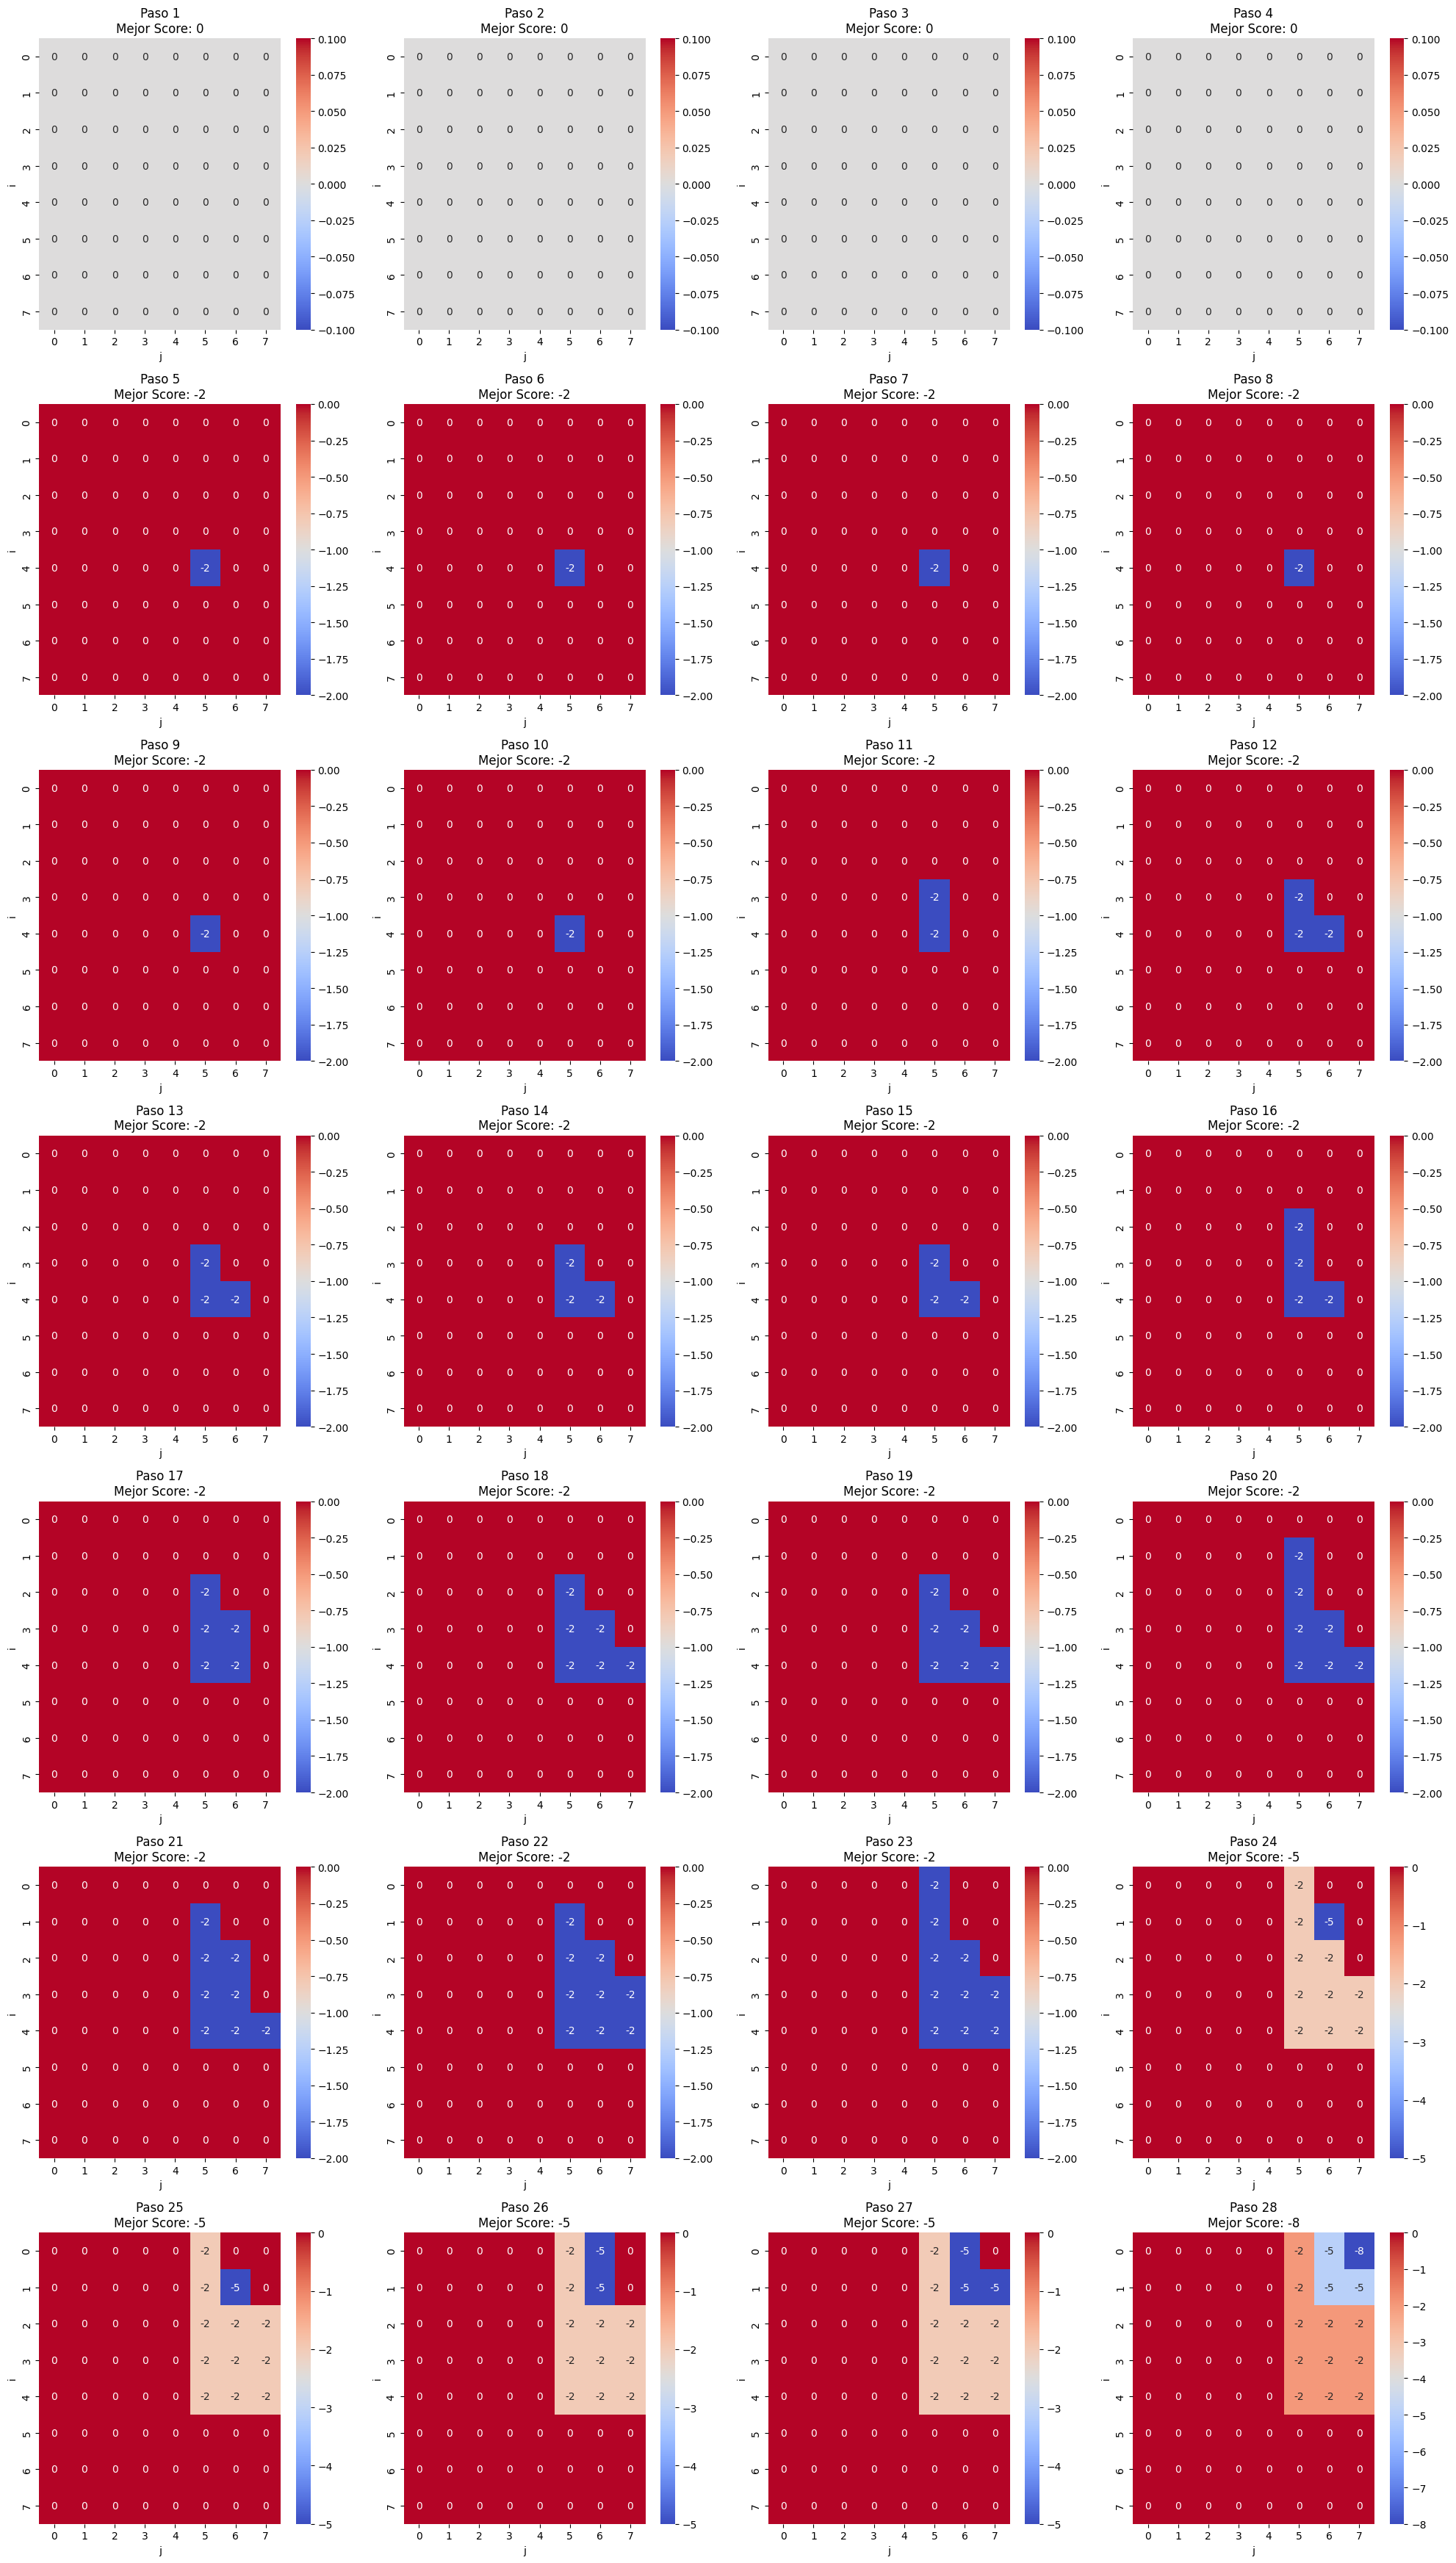


2. Matriz final interactiva:



3. Estructura secundaria y detalles:


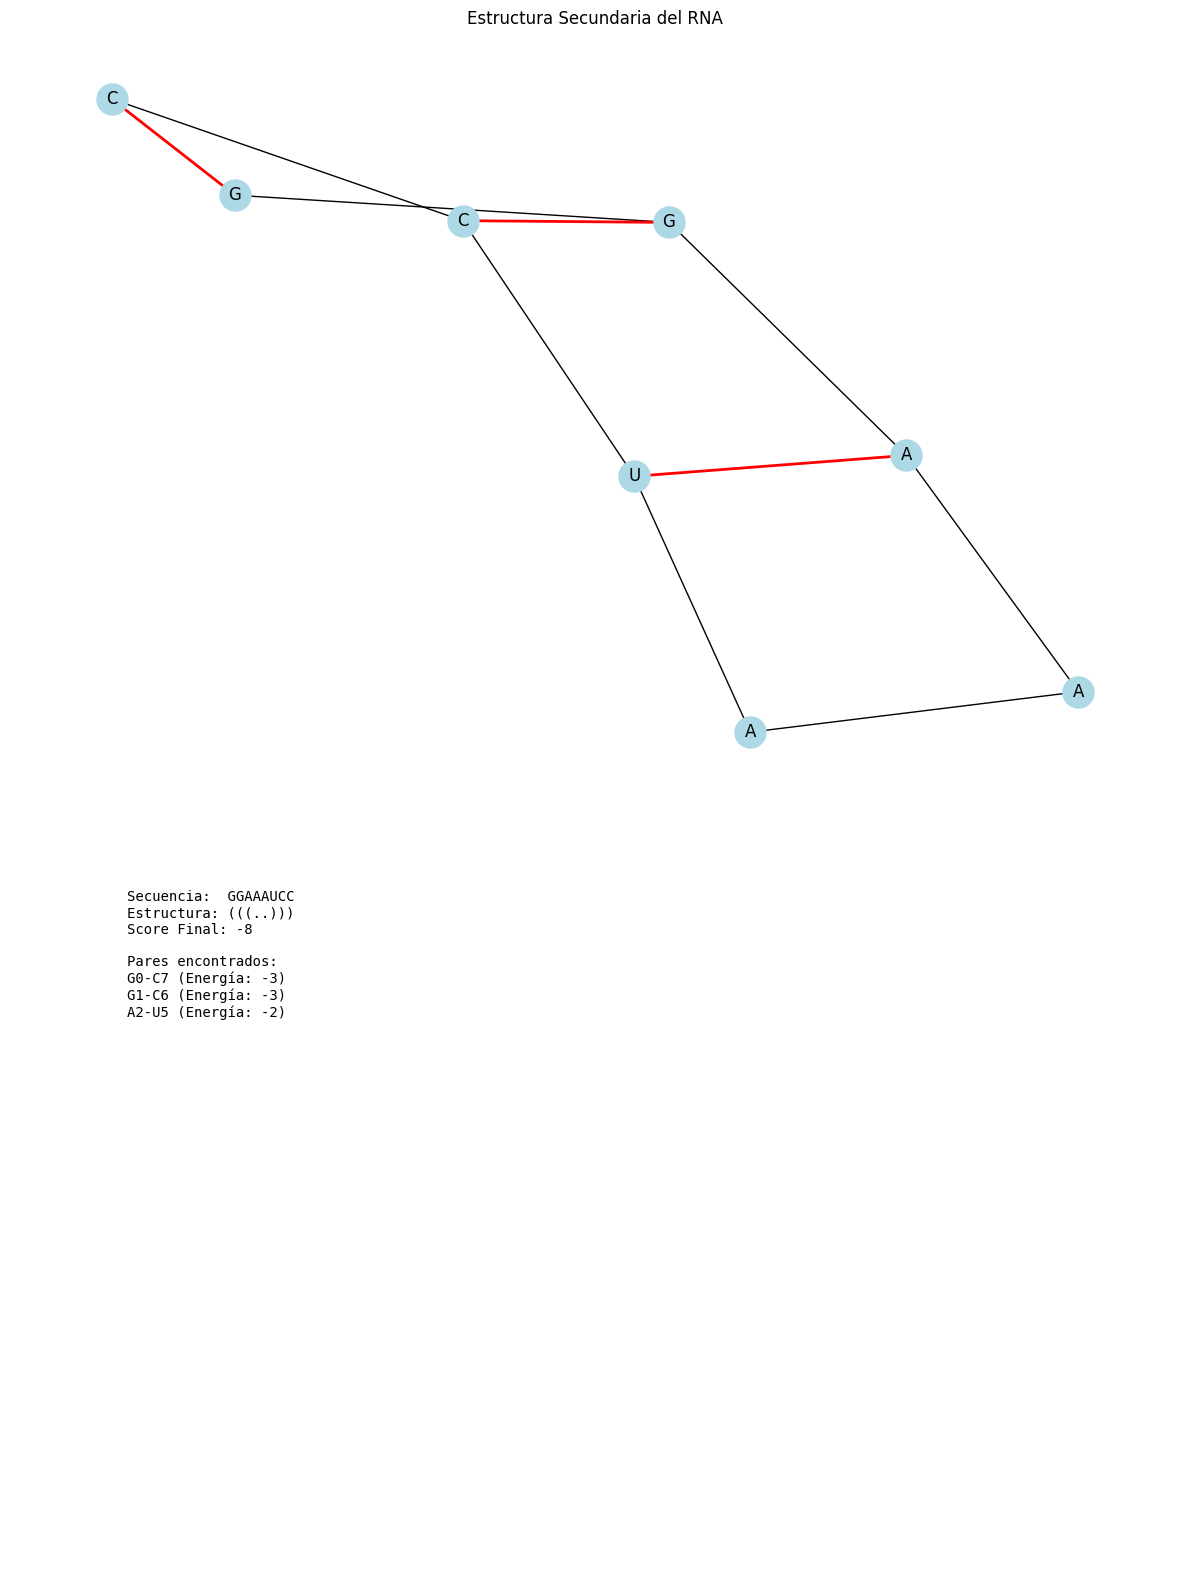




Analizando secuencia: GCGCUUAAGCGC
Analizando secuencia: GCGCUUAAGCGC
Verificando implementación con secuencia: GCGCUUAAGCGC
✓ Verificación completada exitosamente

Score Final (Energía mínima): -16

1. Evolución de la matriz de programación dinámica:


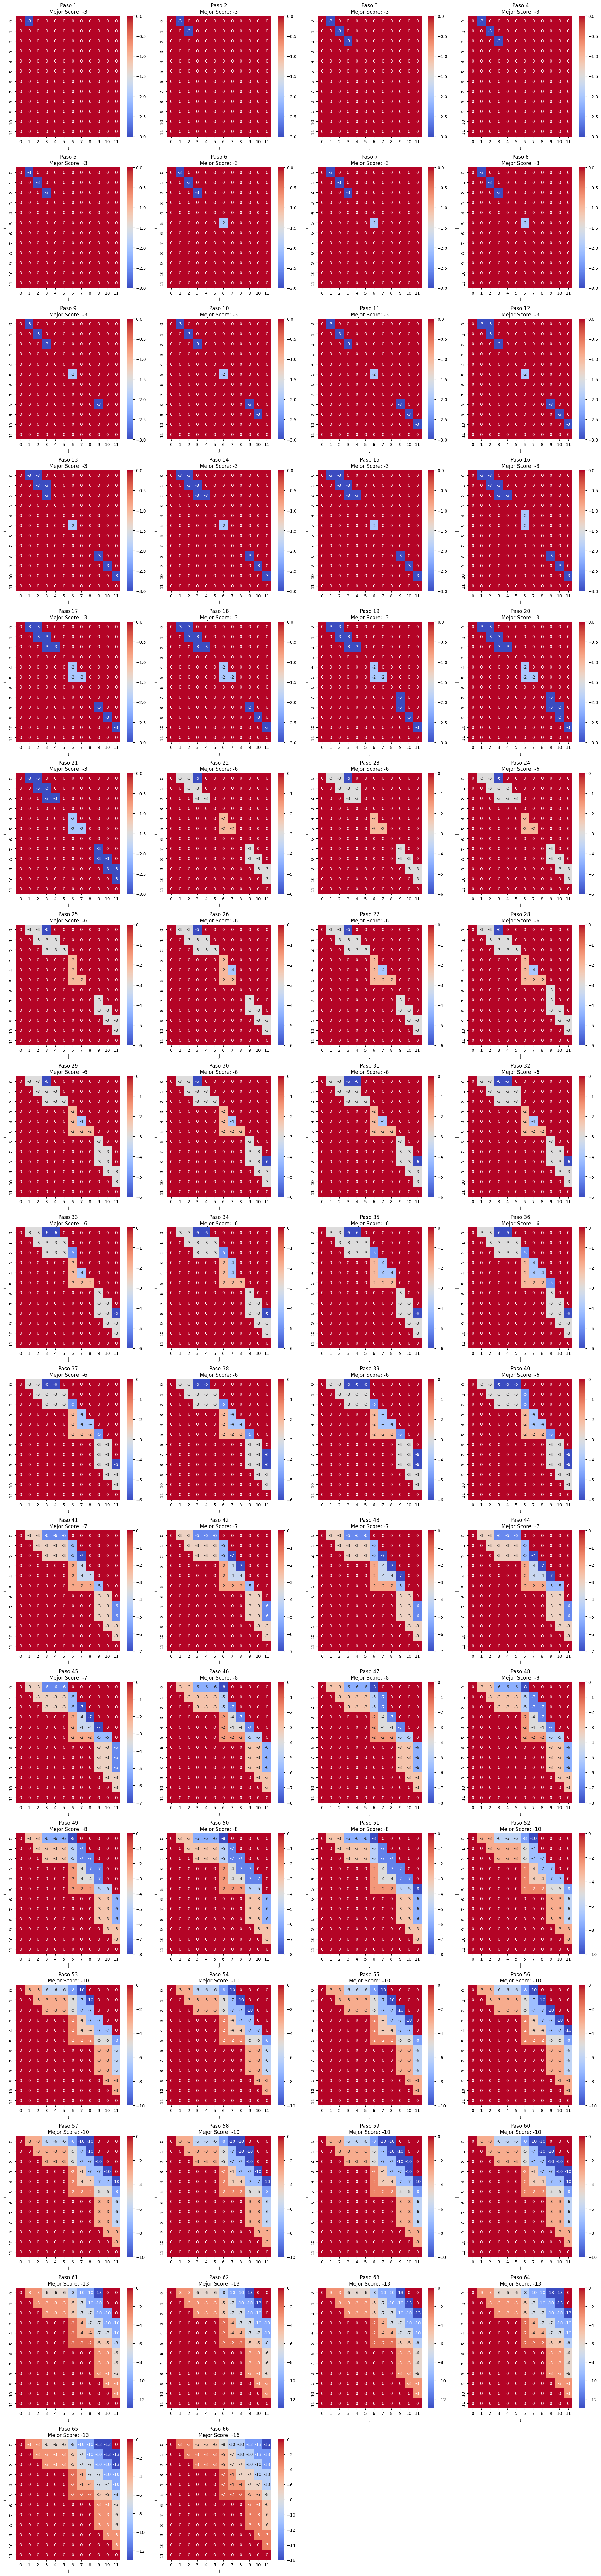


2. Matriz final interactiva:



3. Estructura secundaria y detalles:


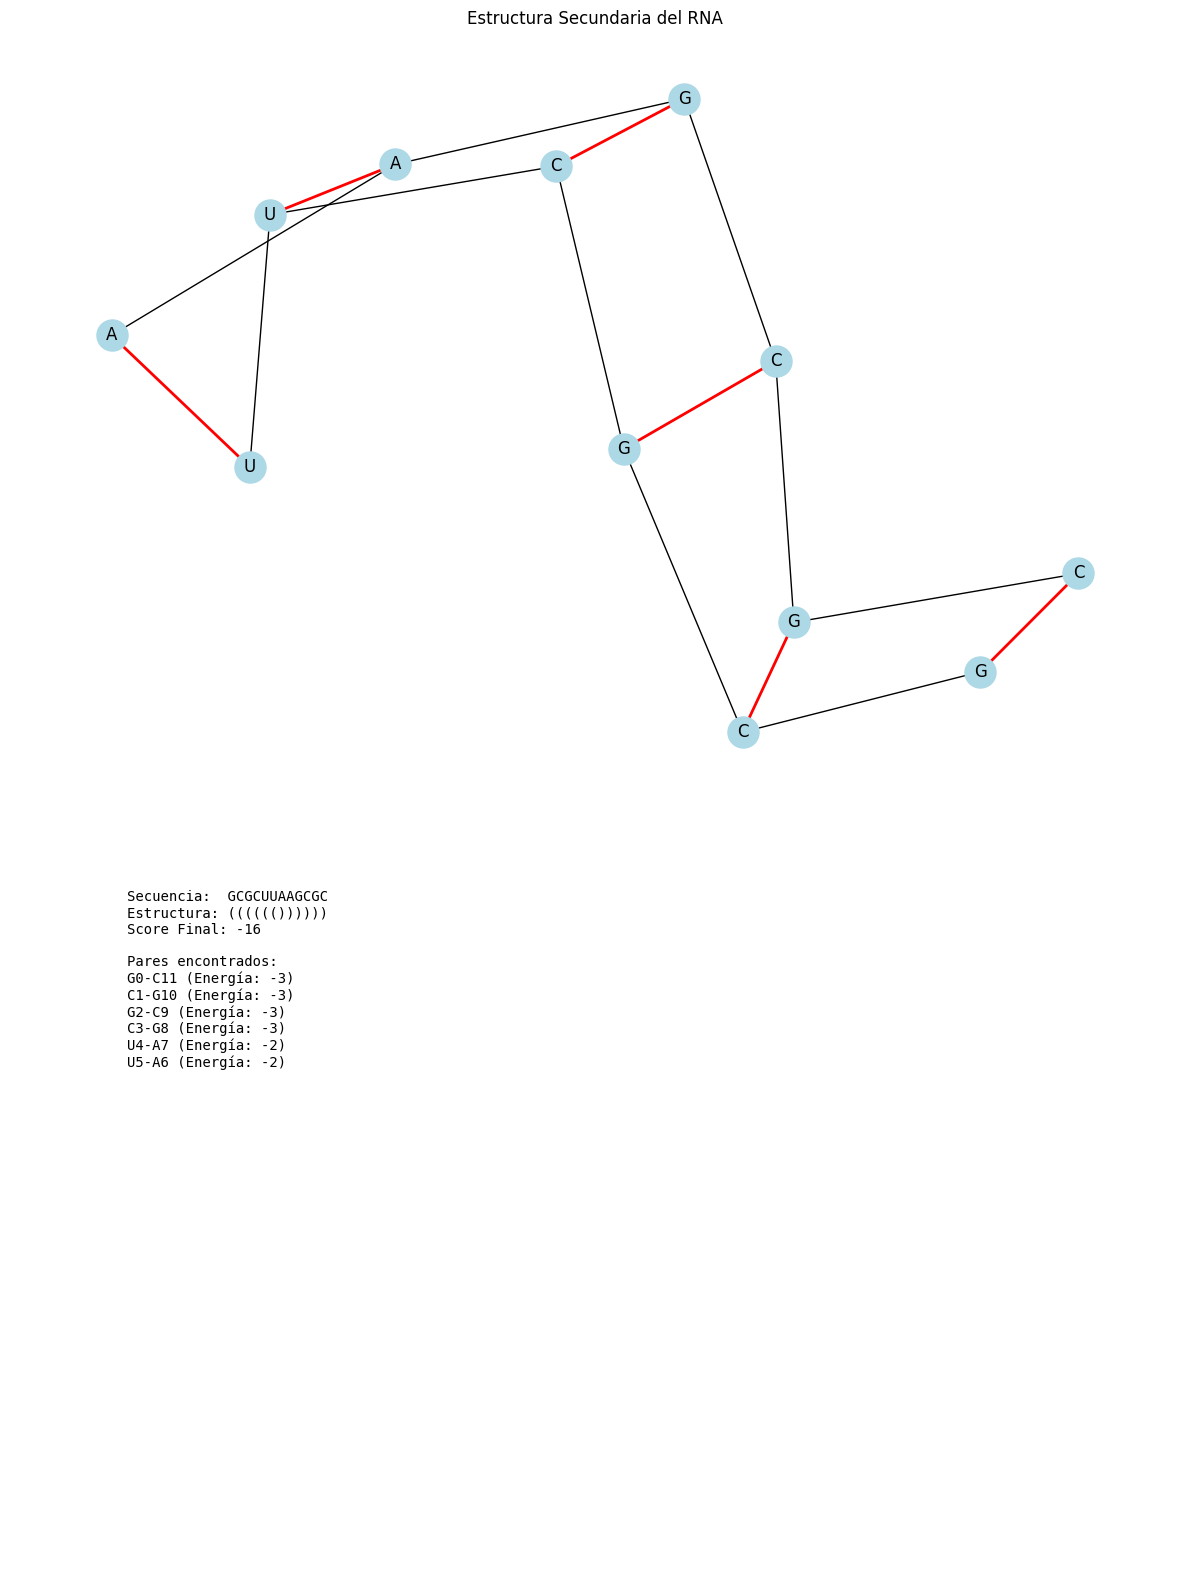




Analizando secuencia: UUCAGAGUCUCU
Analizando secuencia: UUCAGAGUCUCU
Verificando implementación con secuencia: UUCAGAGUCUCU
✓ Verificación completada exitosamente

Score Final (Energía mínima): -10

1. Evolución de la matriz de programación dinámica:


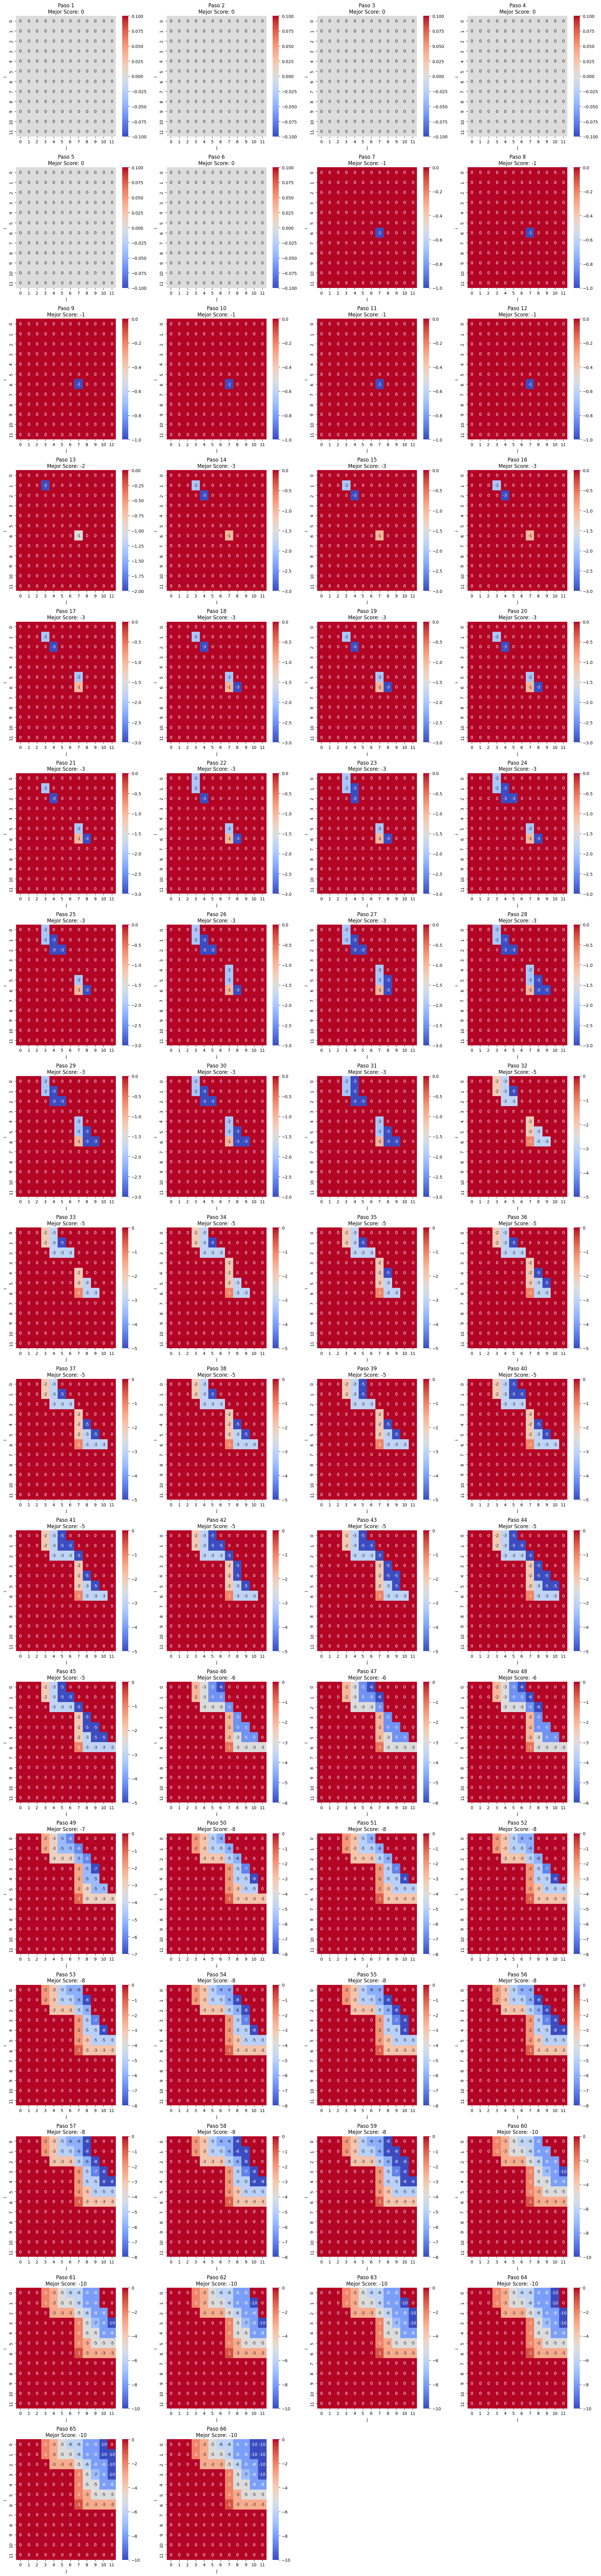


2. Matriz final interactiva:



3. Estructura secundaria y detalles:


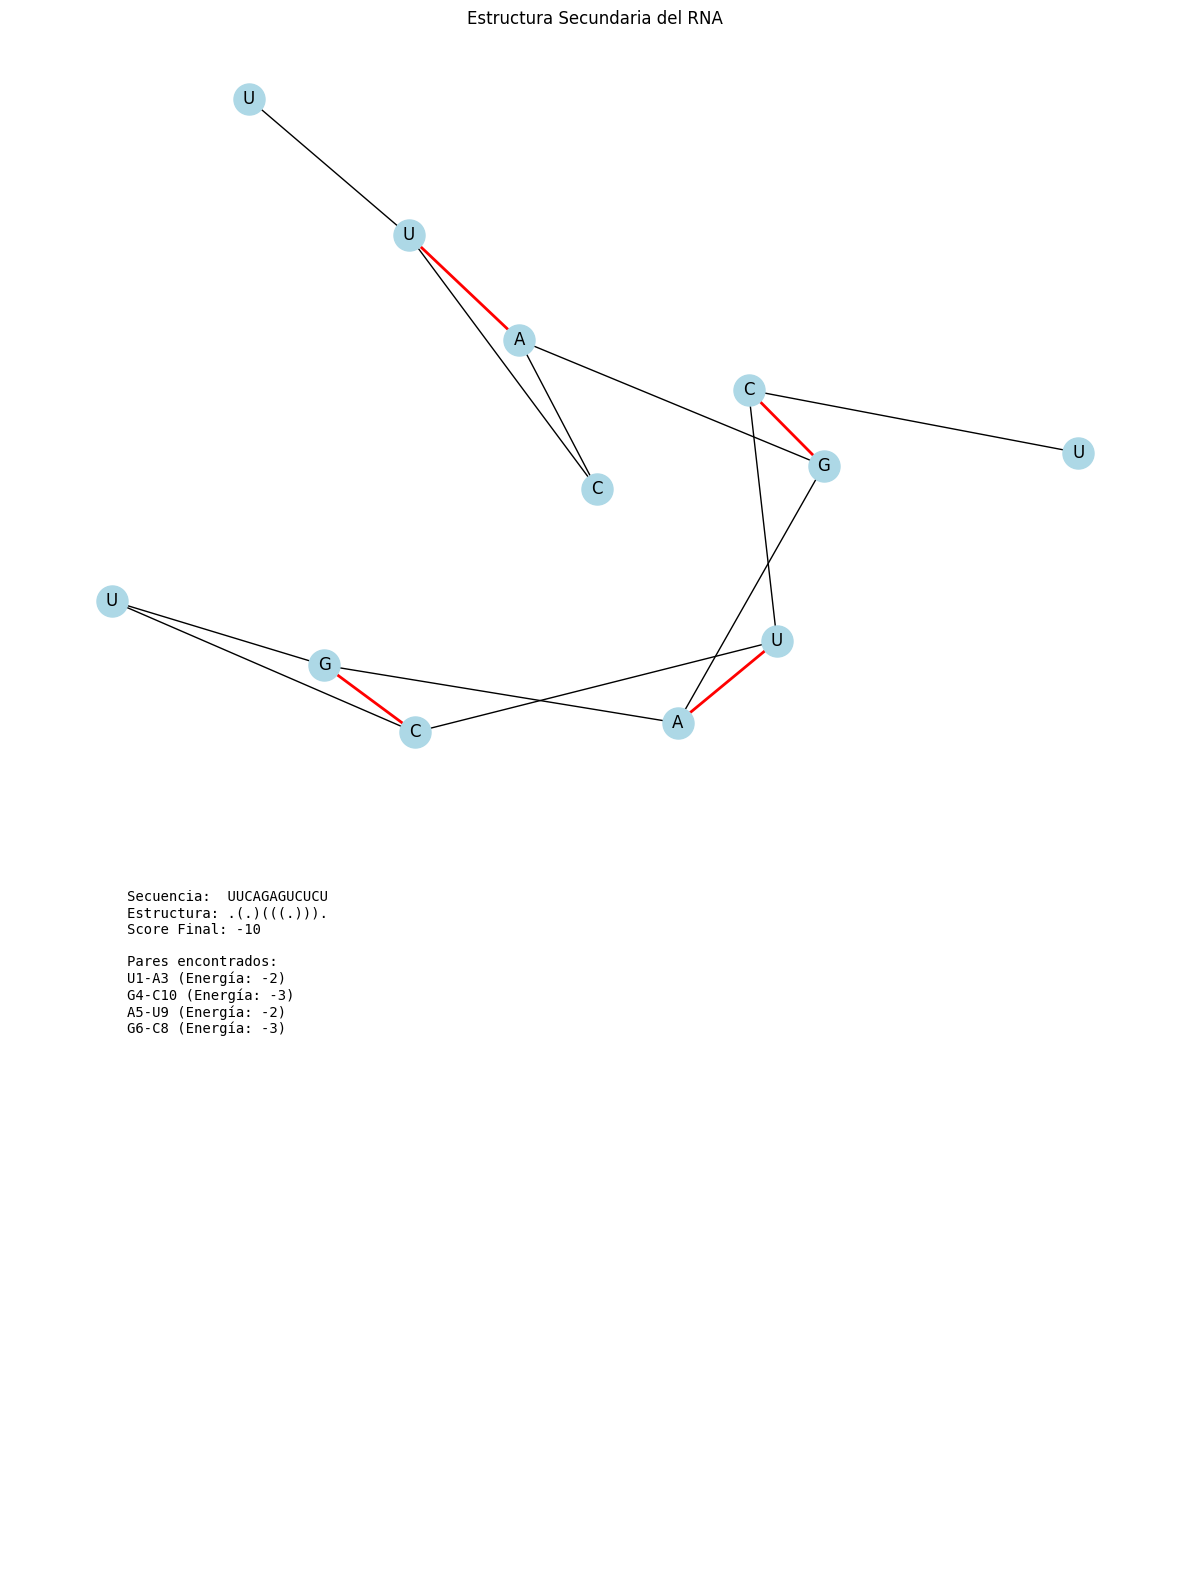

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import networkx as nx
import pandas as pd
import time
from typing import List, Tuple, Dict
import plotly.graph_objects as go
from plotly.subplots import make_subplots

class NussinovRNA:
    def __init__(self, sequence: str):
        """
        Inicializa el algoritmo Nussinov para una secuencia de RNA dada.
        """
        self.sequence = sequence.upper()
        self.n = len(sequence)
        self.dp = np.zeros((self.n, self.n), dtype=int)
        self.history = []  # Para almacenar el historial de matrices
        self.best_scores = []  # Para almacenar los mejores scores en cada iteración

    def can_pair(self, a: str, b: str) -> bool:
        """Verifica si dos bases pueden formar un par."""
        valid_pairs = {
            ('A', 'U'), ('U', 'A'),
            ('C', 'G'), ('G', 'C'),
            ('G', 'U'), ('U', 'G')
        }
        return (a, b) in valid_pairs

    def alpha(self, ri: str, rj: str, use_complex_energy: bool = True) -> int:
        """
        Calcula la energía de apareamiento.
        Valores negativos indican estabilidad (más negativo = más estable)
        """
        if use_complex_energy:
            energy_values = {
                ('C', 'G'): -3, ('G', 'C'): -3,  # Enlaces más fuertes
                ('A', 'U'): -2, ('U', 'A'): -2,  # Enlaces moderados
                ('G', 'U'): -1, ('U', 'G'): -1   # Enlaces más débiles
            }
            return energy_values.get((ri, rj), 0)
        else:
            return -1 if self.can_pair(ri, rj) else 0

    def calculate_matrix(self, use_complex_energy: bool = True, visualize: bool = True):
        """
        Calcula la matriz de programación dinámica con visualización opcional.
        Almacena el mejor score en cada iteración.
        """
        current_best_score = 0

        for l in range(1, self.n):
            for i in range(self.n - l):
                j = i + l

                # Inicializar con el caso de no emparejar j
                self.dp[i,j] = self.dp[i,j-1]

                # Verificar si i y j pueden formar un par
                if self.can_pair(self.sequence[i], self.sequence[j]):
                    energy = self.alpha(self.sequence[i], self.sequence[j], use_complex_energy)
                    if i + 1 <= j - 1:
                        self.dp[i,j] = min(self.dp[i,j], self.dp[i+1,j-1] + energy)
                    else:
                        self.dp[i,j] = min(self.dp[i,j], energy)

                # Verificar todas las posibles divisiones
                for k in range(i, j):
                    self.dp[i,j] = min(self.dp[i,j], self.dp[i,k] + self.dp[k+1,j])

                current_best_score = min(current_best_score, self.dp[i,j])

                if visualize:
                    self.history.append(self.dp.copy())
                    self.best_scores.append(current_best_score)

    def get_final_score(self) -> int:
        """Retorna el score final (energía mínima)."""
        return self.dp[0, self.n-1]

    def traceback(self) -> List[Tuple[int, int]]:
        """Realiza el traceback para encontrar los pares de bases."""
        pairs = []
        self._traceback_helper(0, self.n-1, pairs)
        return sorted(pairs)  # Ordenamos los pares para mejor visualización

    def _traceback_helper(self, i: int, j: int, pairs: List[Tuple[int, int]]):
        """Función auxiliar recursiva para el traceback."""
        if i >= j:
            return

        if self.dp[i,j] == self.dp[i,j-1]:
            self._traceback_helper(i, j-1, pairs)
            return

        if self.can_pair(self.sequence[i], self.sequence[j]):
            energy = self.alpha(self.sequence[i], self.sequence[j])
            if ((i + 1 <= j - 1 and self.dp[i,j] == self.dp[i+1,j-1] + energy) or
                (i + 1 > j - 1 and self.dp[i,j] == energy)):
                pairs.append((i, j))
                self._traceback_helper(i+1, j-1, pairs)
                return

        for k in range(i, j):
            if self.dp[i,j] == self.dp[i,k] + self.dp[k+1,j]:
                self._traceback_helper(i, k, pairs)
                self._traceback_helper(k+1, j, pairs)
                return

    def visualize_matrix_evolution(self):
        """
        Visualiza la evolución de la matriz de programación dinámica
        junto con los mejores scores.
        """
        n_steps = len(self.history)
        n_rows = (n_steps + 3) // 4  # 4 matrices por fila

        fig = plt.figure(figsize=(20, 5*n_rows))
        for idx, (matrix, score) in enumerate(zip(self.history, self.best_scores)):
            plt.subplot(n_rows, 4, idx+1)
            sns.heatmap(matrix, annot=True, fmt='d', cmap='coolwarm')
            plt.title(f'Paso {idx+1}\nMejor Score: {score}')
            plt.xlabel('j')
            plt.ylabel('i')

        plt.tight_layout()
        plt.show()

    def visualize_structure(self):
        """
        Visualiza la estructura secundaria del RNA y muestra información detallada.
        """
        pairs = self.traceback()
        structure = ['.' for _ in range(self.n)]

        # Crear estructura en formato dot-bracket
        for i, j in pairs:
            structure[i] = '('
            structure[j] = ')'

        # Crear el grafo de la estructura
        G = nx.Graph()

        # Añadir nodos y conexiones backbone
        for i in range(self.n):
            G.add_node(i, base=self.sequence[i])
            if i < self.n - 1:
                G.add_edge(i, i+1, color='black', weight=1)

        # Añadir conexiones de pares de bases
        for i, j in pairs:
            G.add_edge(i, j, color='red', weight=2)

        # Configurar el layout
        pos = nx.spring_layout(G, k=1, iterations=50)

        # Crear figura con dos subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))

        # Subplot 1: Grafo de la estructura
        edges = G.edges()
        colors = [G[u][v]['color'] for u, v in edges]
        weights = [G[u][v]['weight'] for u, v in edges]
        nx.draw_networkx_edges(G, pos, edge_color=colors, width=weights, ax=ax1)
        nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500, ax=ax1)
        labels = nx.get_node_attributes(G, 'base')
        nx.draw_networkx_labels(G, pos, labels, ax=ax1)
        ax1.set_title('Estructura Secundaria del RNA')
        ax1.axis('off')

        # Subplot 2: Información textual
        ax2.axis('off')
        info_text = (
            f'Secuencia:  {self.sequence}\n'
            f'Estructura: {"".join(structure)}\n'
            f'Score Final: {self.get_final_score()}\n\n'
            'Pares encontrados:\n' +
            '\n'.join(f'{self.sequence[i]}{i}-{self.sequence[j]}{j} '
                     f'(Energía: {self.alpha(self.sequence[i], self.sequence[j])})'
                     for i, j in pairs)
        )
        ax2.text(0.1, 0.9, info_text, va='top', fontfamily='monospace')

        plt.tight_layout()
        plt.show()

    def plot_interactive_matrix(self):
        """Crea una visualización interactiva de la matriz final usando plotly."""
        fig = go.Figure(data=go.Heatmap(
            z=self.dp,
            text=self.dp,
            texttemplate="%{text}",
            textfont={"size": 10},
            colorscale='RdBu_r'
        ))

        # Añadir la secuencia como etiquetas y el score final
        fig.update_layout(
            title=f'Matriz de Programación Dinámica Final (Score: {self.get_final_score()})',
            xaxis_title='j',
            yaxis_title='i',
            xaxis=dict(
                ticktext=list(self.sequence),
                tickvals=list(range(len(self.sequence)))
            ),
            yaxis=dict(
                ticktext=list(self.sequence),
                tickvals=list(range(len(self.sequence)))
            )
        )

        fig.show()

def verify_implementation(sequence: str):
    """
    Verifica la implementación del algoritmo con pruebas básicas.
    """
    print(f"Verificando implementación con secuencia: {sequence}")

    # Verificar secuencia válida
    if not all(base in 'ACGU' for base in sequence.upper()):
        raise ValueError("Secuencia inválida. Use solo bases A, C, G, U")

    # Crear instancia y calcular
    rna = NussinovRNA(sequence)
    rna.calculate_matrix()

    # Verificar matriz
    assert rna.dp.shape == (len(sequence), len(sequence)), "Dimensiones de matriz incorrectas"
    assert np.all(rna.dp[np.tril_indices(len(sequence), -1)] == 0), "Valores incorrectos bajo la diagonal"

    # Verificar pares
    pairs = rna.traceback()
    for i, j in pairs:
        assert rna.can_pair(sequence[i], sequence[j]), f"Par inválido: {sequence[i]}-{sequence[j]}"
        assert i < j, "Índices de pares inválidos"

    # Verificar que no hay cruces en los pares
    sorted_pairs = sorted(pairs)
    for idx in range(len(sorted_pairs)-1):
        i1, j1 = sorted_pairs[idx]
        i2, j2 = sorted_pairs[idx+1]
        assert not (i1 < i2 < j1 < j2), "Se detectaron pares cruzados"

    print("✓ Verificación completada exitosamente")
    return True

def run_analysis(sequence: str):
    """
    Ejecuta el análisis completo para una secuencia dada.
    """
    print(f"Analizando secuencia: {sequence}")

    # Verificar la implementación
    verify_implementation(sequence)

    # Inicializar y calcular
    rna = NussinovRNA(sequence)
    rna.calculate_matrix(visualize=True)

    # Mostrar score final
    print(f"\nScore Final (Energía mínima): {rna.get_final_score()}")

    # Visualizaciones
    print("\n1. Evolución de la matriz de programación dinámica:")
    rna.visualize_matrix_evolution()

    print("\n2. Matriz final interactiva:")
    rna.plot_interactive_matrix()

    print("\n3. Estructura secundaria y detalles:")
    rna.visualize_structure()

# Ejemplo de uso y pruebas
if __name__ == "__main__":
    # Probar con diferentes secuencias
    test_sequences = [
        "GGAAAUCC",
        "GCGCUUAAGCGC",
        "UUCAGAGUCUCU"
    ]

    for seq in test_sequences:
        print(f"\nAnalizando secuencia: {seq}")
        print("="* 50)
        run_analysis(seq)
        print("\n")